In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo, get_performance, plot_roc_curve
from train_utils import pull_tiles, FocalLoss, get_feature_idexes
from train_utils import convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from ACMIL import ACMIL_GA_MultiTask, predict_v2, train_one_epoch_multitask_V2, evaluate_multitask_V2
warnings.filterwarnings("ignore")
%matplotlib inline


#FOR ACMIL
current_dir = os.getcwd()
grandparent_subfolder = os.path.join(current_dir, '..', '..', 'other_model_code','ACMIL-main')
grandparent_subfolder = os.path.normpath(grandparent_subfolder)
sys.path.insert(0, grandparent_subfolder)
from utils.utils import save_model, Struct, set_seed
import yaml
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import yaml
from pprint import pprint

import argparse
import torch
from torch.utils.data import DataLoader

from utils.utils import save_model, Struct, set_seed
from datasets.datasets import build_HDF5_feat_dataset
from architecture.transformer import ACMIL_GA #ACMIL_GA
from architecture.transformer import ACMIL_MHA
import torch.nn.functional as F
import wandb


from sklearn.isotonic import IsotonicRegression

def calibrate_probs_isotonic(y_val, y_prob_val, y_test_prob):
    """
    Perform Isotonic Regression to calibrate predicted probabilities.

    Args:
        y_val: Ground truth labels from the validation set.
        y_prob_val: Model-predicted probabilities from the validation set.
        y_test_prob: Model-predicted probabilities for the test set.

    Returns:
        Calibrated probabilities for the test set.
    """
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(y_prob_val, y_val)
    calibrated_probs = iso_reg.predict(y_test_prob)
    return calibrated_probs

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score,average_precision_score
from sklearn import metrics
def bootstrap_ci_from_df(df, metric_fn, y_true_col='y_true', y_pred_col=None, y_prob_col=None,
                         num_bootstrap=1000, ci=95, seed=None):
    """
    Compute bootstrap confidence interval for a metric using predictions in a DataFrame.

    Args:
        df: DataFrame with prediction results.
        metric_fn: Metric function. Can accept (y_true, y_pred) or (y_true, y_prob).
        y_true_col: Column name for ground truth.
        y_pred_col: Column name for predicted labels (used for accuracy, etc.).
        y_prob_col: Column name for predicted probabilities (used for AUROC, etc.).
        num_bootstrap: Number of bootstrap resamples.
        ci: Confidence level (e.g., 95 for 95% CI).
        seed: Optional random seed.

    Returns:
        (lower_bound, upper_bound) of CI.
    """
    rng = np.random.default_rng(seed)
    n = len(df)
    perf_list = []

    for _ in range(num_bootstrap):
        sample = df.sample(n=n, replace=True, random_state=rng.integers(0, 1e6))
        y_true = sample[y_true_col].values
        y_pred_class =  sample[y_pred_col].values
        y_pred_prob =   sample[y_prob_col].values

        # mean_metric = np.mean(metrics)
        # metric = metric_fn(y_true, y_pred_or_prob)
        # metrics.append(metric)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class).ravel() #CM
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
        PR_AUC = average_precision_score(y_true, y_pred_prob)
        AUC = round(metrics.auc(fpr, tpr),2)
        ACC = round(accuracy_score(y_true, y_pred_class),2)
        F1 = round(f1_score(y_true, y_pred_class),2)
        F2 = round(fbeta_score(y_true, y_pred_class,beta = 2),2)
        F3 = round(fbeta_score(y_true, y_pred_class,beta = 3),2)
        Recall = round(recall_score(y_true, y_pred_class),2)
        Precision = round(precision_score(y_true, y_pred_class),2)
        Specificity = round(tn / (tn + fp),2)
        perf_tb = pd.DataFrame({"AUC": AUC,
                                "Recall": Recall,
                                "Specificity":Specificity,
                                "ACC": ACC,
                                "Precision":Precision,
                                "PR_AUC":PR_AUC,
                                "F1": F1,
                                "F2": F2,
                                "F3": F3},index = [0])
        perf_list.append(perf_tb)
    perf_df = pd.concat(perf_list)

    mean_values = perf_df.mean()
    lower_bounds = perf_df.quantile((100 - ci) / 200)
    upper_bounds = perf_df.quantile(1 - (100 - ci) / 200)
    
    formatted_results = {
        column: f"{mean_values[column]:.2f} [{lower_bounds[column]:.2f} - {upper_bounds[column]:.2f}]"
        for column in perf_df.columns
    }
    ci_df = pd.DataFrame.from_dict(formatted_results, orient="index", columns=["Mean [CI Low, CI High]"])

    return ci_df.T

In [2]:
####################################
######      USERINPUT       ########
####################################
ALL_LABEL = ["AR","HR","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TUMOR_FRAC_THRES = 0.9 
feature_extraction_method = 'uni2' #retccl, uni1, prov_gigapath
learning_method = "abmil"
SELECTED_FEATURE = get_feature_idexes(feature_extraction_method, include_tumor_fraction = False)
N_FEATURE = len(SELECTED_FEATURE)


#For RB1: gamma = 2, focal_alpha = 0.1


# Define different values for alpha and gamma
alpha_values = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.6]  # Example alpha values
gamma_values = [2,    3,    2,   2,  2,   2,  10]  # Example gamma values

# focal_gamma = 5 #10 seems good too
# focal_alpha = 0.80
#Best before
focal_gamma = 10
focal_alpha = 0.6
loss_method = 'ATTLOSS' #ATTLOSS

################################
#model Para
BATCH_SIZE  = 1
DROPOUT = 0
DIM_OUT = 128
SELECTED_MUTATION = "MT"
SELECTED_FOLD = 0
arch = 'ga_mt' #ga_mt or ga

    
################################
# get config
config_dir = "myconf.yml"
with open(config_dir, "r") as ymlfile:
    c = yaml.load(ymlfile, Loader=yaml.FullLoader)
    #c.update(vars(args))
    conf = Struct(**c)

conf.train_epoch = 100
conf.D_feat = N_FEATURE
conf.D_inner = DIM_OUT

if learning_method == 'abmil':
    conf.n_token = 1
    conf.mask_drop = 0
    conf.n_masked_patch = 0
elif learning_method == 'acmil':
    conf.n_token = 3
    conf.mask_drop = 0.6
    conf.n_masked_patch = 0
    
conf.n_class = 1
conf.wandb_mode = 'disabled'
conf.n_task = 7
#conf.lr = 0.000001 #change this for HR only

# Print all key-value pairs in the conf object
for key, value in conf.__dict__.items():
    print(f"{key}: {value}")
    
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name_overlap = "IMSIZE250_OL100"
folder_name_nonoverlap = "IMSIZE250_OL0"
feature_path_opx_train =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_overlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
feature_path_opx_test =  os.path.join(proj_dir + 'intermediate_data/5_model_ready_data', "OPX", folder_name_nonoverlap, 'feature_' + feature_extraction_method, 'TFT' + str(TUMOR_FRAC_THRES))
train_val_test_id_path =  os.path.join(proj_dir + 'intermediate_data/6_Train_TEST_IDS', 'TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES))


train_epoch: 100
warmup_epoch: 0
wd: 1e-05
lr: 0.0001
min_lr: 0
dataset: bracs
B: 1
n_class: 1
n_worker: 8
pin_memory: False
n_shot: -1
D_feat: 1536
D_inner: 128
n_token: 1
mask_drop: 0
n_masked_patch: 0
wandb_mode: disabled
n_task: 7


In [3]:
######################
#Create output-dir
################################################
folder_name1 = feature_extraction_method + '/TrainOL100_TestOL0_TFT' + str(TUMOR_FRAC_THRES)  + "/"
outdir0 =  proj_dir + "intermediate_data/pred_out032025_ACMIL2" + "/" + folder_name1 + 'FOLD' + str(SELECTED_FOLD) + '/' + SELECTED_MUTATION + "/" 
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"


create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)
create_dir_if_not_exists(outdir5)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//model_para/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//logs/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//perf/' created.
cuda:0


In [4]:
################################################
#     Model ready data 
################################################
opx_data_ol100 = torch.load(feature_path_opx_train + '/OPX_data.pth')
opx_data_ol0 = torch.load(feature_path_opx_test + '/OPX_data.pth')

In [5]:
################################################
#Get train, test IDs
################################################
train_test_val_id_df = pd.read_csv(os.path.join(train_val_test_id_path, "train_test_split.csv"))
train_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TRAIN', 'SAMPLE_ID'])
test_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'TEST', 'SAMPLE_ID'])
val_ids_all = list(train_test_val_id_df.loc[train_test_val_id_df['FOLD' + str(SELECTED_FOLD)] == 'VALID', 'SAMPLE_ID'])

In [6]:
print(len(train_ids_all))
print(len(test_ids_all))
print(len(val_ids_all))

161
67
40


In [7]:
################################################
#IDS
################################################
opx_ids_ol100 = [x[-2] for x in opx_data_ol100]
opx_ids_ol0 = [x[-2] for x in opx_data_ol0]

In [8]:
################################################
#Get Train, test, val data
################################################
#Train:
inc_idx = [opx_ids_ol100.index(x) for x in train_ids_all]
train_data = Subset(opx_data_ol100, inc_idx)
train_ids =  list(Subset(opx_ids_ol100, inc_idx))

#Val:
inc_idx = [opx_ids_ol100.index(x) for x in val_ids_all]
val_data = Subset(opx_data_ol100, inc_idx)
val_ids =  list(Subset(opx_ids_ol100, inc_idx))

#Test:
inc_idx = [opx_ids_ol0.index(x) for x in test_ids_all]
test_data = Subset(opx_data_ol0, inc_idx)
test_ids =  list(Subset(opx_ids_ol0, inc_idx))

In [9]:
####################################################
#Dataloader for training
####################################################
train_data2 = [item[:-3] for item in train_data] #only keep the needed for training
test_data2 = [item[:-3] for item in test_data] #only keep the needed for training
val_data2 = [item[:-3] for item in val_data] #only keep the needed for training

train_loader = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data2, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data2, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
####################################################
# define network
####################################################
if arch == 'ga':
    model = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
elif arch == 'ga_mt':
    model = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
else:
    model = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
model.to(device)


# Create a list of FocalLoss criteria with different alpha and gamma
criterion = [FocalLoss(alpha=a, gamma=g, reduction='mean') for a, g in zip(alpha_values, gamma_values)]
#criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction='mean')

# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)

ckpt_dir = outdir1 + SELECTED_MUTATION + "/"
create_dir_if_not_exists(ckpt_dir)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//saved_model/MT/' created.


In [11]:
####################################################
#            Train 
####################################################
set_seed(0)
# define optimizer, lr not important at this point
optimizer0 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=conf.wd)
best_state = {'epoch':-1, 'val_acc':0, 'val_auc':0, 'val_f1':0, 'test_acc':0, 'test_auc':0, 'test_f1':0}
train_epoch = conf.train_epoch
for epoch in range(train_epoch):
    # train_one_epoch_multitask(model, criterion, train_loader, optimizer0, device, epoch, conf, loss_method)
    # val_auc, val_acc, val_f1, val_loss = evaluate_multitask(model, criterion, val_loader, device, conf, 'Val')
    # test_auc, test_acc, test_f1, test_loss = evaluate_multitask(model, criterion, test_loader, device, conf, 'Test')
    train_one_epoch_multitask_V2(model, criterion, train_loader, optimizer0, device, epoch, conf, loss_method)
    val_auc, val_acc, val_f1, val_loss = evaluate_multitask_V2(model, criterion, val_loader, device, conf, 'Val')
    test_auc, test_acc, test_f1, test_loss = evaluate_multitask_V2(model, criterion, test_loader, device, conf, 'Test')

    save_model(conf=conf, model=model, optimizer=optimizer0, epoch=epoch,
        save_path=os.path.join(ckpt_dir + 'checkpoint_' + 'epoch' + str(epoch) + '.pth'))
print("Results on best epoch:")
print(best_state)
wandb.finish()

Epoch: [0]  [  0/161]  eta: 0:01:14  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.0000 (0.0000)  slide_loss: 0.0002 (0.0002)  att_loss: 0.8079 (0.8079)  total_loss: 6.1950 (6.1950)  time: 0.4605  data: 0.0007  max mem: 26
Epoch: [0]  [100/161]  eta: 0:00:01  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.0000 (0.0000)  slide_loss: 0.0000 (0.0007)  att_loss: 0.9806 (0.9656)  total_loss: 6.9655 (7.0597)  time: 0.0123  data: 0.0015  max mem: 891
Epoch: [0]  [160/161]  eta: 0:00:00  lr: 0.000100  sub_loss: 0.0000 (0.0000)  diff_loss: 0.0000 (0.0000)  slide_loss: 0.0000 (0.0005)  att_loss: 0.9844 (0.9691)  total_loss: 7.0337 (7.0183)  time: 0.0132  data: 0.0017  max mem: 891
Epoch: [0] Total time: 0:00:02 (0.0166 s / it)
Val  [ 0/40]  eta: 0:00:00  loss: 0.0839 (0.0839)  div_loss: -64.2894 (-64.2894)  acc1: 85.7143 (85.7143)  time: 0.0140  data: 0.0026  max mem: 891
Val  [39/40]  eta: 0:00:00  loss: 0.0943 (0.1238)  div_loss: -51.7462 (-50.1866)  acc1: 85.7143 (83.5714)  tim

In [12]:
# ###################################################
# #           Test 
# ###################################################
# # define network
# if arch == 'ga':
#     model2 = ACMIL_GA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop)
# elif arch == 'ga_mt':
#     model2 = ACMIL_GA_MultiTask(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop= conf.mask_drop, n_task = conf.n_task)
# else:
#     model2 = ACMIL_MHA(conf, n_token=conf.n_token, n_masked_patch=conf.n_masked_patch, mask_drop=conf.mask_drop)
# model2.to(device)

# # Load the checkpoint
# #checkpoint = torch.load(ckpt_dir + 'checkpoint-best.pth')
# checkpoint = torch.load(ckpt_dir + 'checkpoint_epoch99.pth')

# # Load the state_dict into the model
# model2.load_state_dict(checkpoint['model'])

y_pred_tasks_test, y_predprob_task_test, y_true_task_test = predict_v2(model, test_loader, device, conf, 'Test')
y_pred_tasks_val,  y_predprob_task_val, y_true_task_val = predict_v2(model, val_loader, device, conf, 'Test')


pred_df_list = []
perf_df_list = []
for i in range(conf.n_task):
    #Calibration
    #prob_calibrated = calibrate_probs_isotonic(y_true_task_val[i], y_predprob_task_val[i], y_predprob_task_test[i])
    pred_df, perf_df = get_performance(y_predprob_task_test[i], y_true_task_test[i], test_ids, ALL_LABEL[i], THRES = 0.5)
    pred_df_list.append(pred_df)
    perf_df_list.append(perf_df)

all_perd_df = pd.concat(pred_df_list)
all_perf_df = pd.concat(perf_df_list)
print(all_perf_df)

all_perd_df.to_csv(outdir4 + "/n_token" + str(conf.n_token) + "_TEST_pred_df.csv",index = False)
all_perf_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TEST_perf.csv",index = True)
print(round(all_perf_df['AUC'].mean(),2))

               AUC  Recall  Specificity   ACC  Precision    PR_AUC    F1  \
SAMPLE_LEVEL  0.79    0.43         0.93  0.88       0.43  0.394683  0.43   
SAMPLE_LEVEL  0.70    0.38         0.98  0.91       0.75  0.594513  0.50   
SAMPLE_LEVEL  0.62    0.13         0.90  0.73       0.29  0.310475  0.18   
SAMPLE_LEVEL  1.00    0.86         0.98  0.97       0.86  0.968254  0.86   
SAMPLE_LEVEL  0.73    0.41         0.86  0.75       0.50  0.526308  0.45   
SAMPLE_LEVEL  0.68    0.09         1.00  0.85       1.00  0.411357  0.17   
SAMPLE_LEVEL  0.68    0.08         0.98  0.82       0.50  0.349305  0.14   

                F2    F3                  OUTCOME  
SAMPLE_LEVEL  0.43  0.43                       AR  
SAMPLE_LEVEL  0.42  0.39                       HR  
SAMPLE_LEVEL  0.15  0.14                     PTEN  
SAMPLE_LEVEL  0.86  0.86                      RB1  
SAMPLE_LEVEL  0.43  0.42                     TP53  
SAMPLE_LEVEL  0.11  0.10  TMB_HIGHorINTERMEDITATE  
SAMPLE_LEVEL  0.10  0.09   

In [13]:
#bootstrap perforance
ci_list = []
for i in range(conf.n_task):
    print(i)
    cur_pred_df = all_perd_df.loc[all_perd_df['OUTCOME'] == ALL_LABEL[i]]
    cur_ci_df = bootstrap_ci_from_df(cur_pred_df, roc_auc_score, y_true_col='Y_True', y_pred_col='Pred_Class', y_prob_col='Pred_Prob', num_bootstrap=1000, ci=95, seed=42)
    cur_ci_df['OUTCOME'] = ALL_LABEL[i]
    ci_list.append(cur_ci_df)
ci_final_df = pd.concat(ci_list)
ci_final_df.to_csv(outdir5 + "/n_token" + str(conf.n_token) + "_TEST_perf_bootstrap.csv",index = True)

0
1
2
3
4
5
6


In [14]:
pred_msi = all_perd_df.loc[all_perd_df['OUTCOME'] == 'MSI_POS']
pred_msi

,SAMPLE_IDs,Y_True,Pred_Prob,OUTCOME,Pred_Class
0,OPX_002,0,0.225377,MSI_POS,0
1,OPX_007,1,0.265897,MSI_POS,0
2,OPX_015,0,0.237645,MSI_POS,0
3,OPX_019,0,0.174435,MSI_POS,0
4,OPX_020,0,0.238731,MSI_POS,0
...,...,...,...,...,...
62,OPX_319,0,0.247376,MSI_POS,0
63,OPX_325,0,0.357763,MSI_POS,0
64,OPX_337,0,0.363420,MSI_POS,0
65,OPX_345,0,0.176374,MSI_POS,0


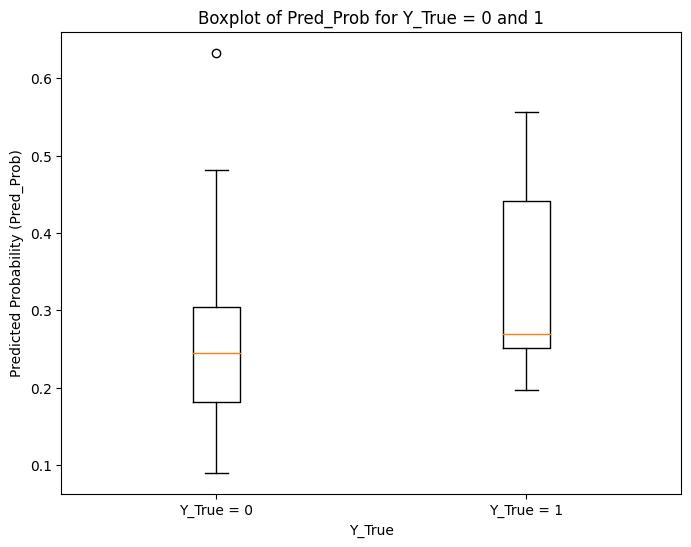

In [15]:
# Separate Pred_Prob values based on Y_True values
pred_prob_0 = pred_msi[pred_msi["Y_True"] == 0]["Pred_Prob"]
pred_prob_1 = pred_msi[pred_msi["Y_True"] == 1]["Pred_Prob"]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([pred_prob_0, pred_prob_1], labels=["Y_True = 0", "Y_True = 1"])

# Add labels and title
plt.xlabel("Y_True")
plt.ylabel("Predicted Probability (Pred_Prob)")
plt.title("Boxplot of Pred_Prob for Y_True = 0 and 1")

# Show the plot
plt.show()

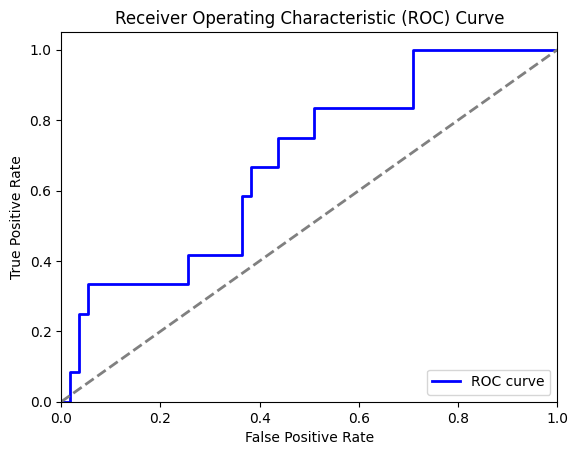

In [16]:
plot_roc_curve(list(pred_msi['Pred_Prob']),list(pred_msi['Y_True']))

In [17]:
#PLOT:
pred_df = all_perd_df
SELECTED_LABEL = ['MSI_POS']
#Get True Postives
true_postive_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_postive_ids[label] = cur_ids

#Get true nagative
true_negative_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_negative_ids[label] = cur_ids

In [18]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 0
mag_extract = 20
limit_bounds = True
TOP_K = 5
mag_target_prob = 2.5
smooth = True
mag_target_tiss = 1.25

def get_attention_and_tileinfo(pt_label_df, patient_att_score):    
    #Get label
    pt_label_df.reset_index(drop = True, inplace = True)

    #Get attention
    cur_att  = pd.DataFrame({'ATT':list(minmax_normalize(patient_att_score))})
    cur_att.reset_index(drop = True, inplace = True)

    #Comb
    cur_att_df = pd.concat([pt_label_df,cur_att], axis = 1)
    cur_att_df.reset_index(drop = True, inplace = True)

    return cur_att_df

In [19]:
#Load all test data
opx_data_ol0 = torch.load(feature_path_opx_test + '/OPX_data.pth')
opx_ids_ol0 = [x[-2] for x in opx_data_ol0]

OPX_075
OPX_075
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/MSI_POS/OPX_075/' created.
post-processing


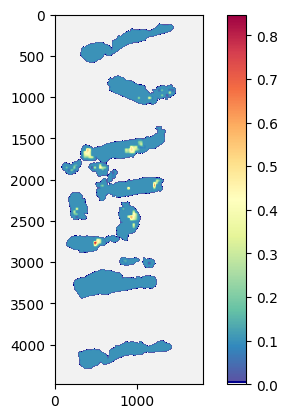

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/MSI_POS/OPX_075/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out032025_ACMIL2/uni2/TrainOL100_TestOL0_TFT0.9/FOLD0/MT//predictions/MSI_POS/OPX_075/bot_tiles/' created.


In [20]:
selected_ids = true_postive_ids[SELECTED_LABEL[0]]
wsi_path = proj_dir + '/data/OPX/'
#branches = 2

for pt in selected_ids:
    i =  opx_ids_ol0.index(pt)
    print(pt)
    print(opx_ids_ol0[i])

    save_location = outdir4 + SELECTED_LABEL[0] + "/"
    save_location =  save_location  + pt + "/"
    create_dir_if_not_exists(save_location)
    
    _file = wsi_path + pt + ".tif"
    oslide = openslide.OpenSlide(_file)
    save_name = str(Path(os.path.basename(_file)).with_suffix(''))


    first_batch = opx_data_ol0[i]
    feat = first_batch[0].unsqueeze(0).to(device)
    sub_preds, slide_preds, attn = model(feat)
    label_index = ALL_LABEL.index(SELECTED_LABEL[0])

    #Get attention
    cur_att = attn[label_index] #att no softmax 
    #cur_att_softmax = torch.softmax(cur_att, dim=-1) #att softmax over tiles

    #Mean
    cur_pt_att = cur_att.mean(dim = 1).squeeze().cpu().detach().numpy() #Mean aross channels without softmax
    #cur_pt_att = cur_att_softmax.mean(dim = 1).squeeze().cpu().detach().numpy()  #Mean aross channels with softmax
    
    #cur_pt_att = cur_att[0,branches,:].cpu().detach().numpy() #branch
    
    #Get all tile info include noncancer tile
    alltileinfo_dir = proj_dir + 'intermediate_data/2_cancer_detection/OPX/' + "IMSIZE250_OL0" + "/"
    tile_info_df = pd.read_csv(alltileinfo_dir + pt + "/ft_model/"  + save_name + "_TILE_TUMOR_PERC.csv")
    #Combine current pt_info an all tile info
    #cur_pt_info = tile_info_df.merge(cur_pt_info, on = list(tile_info_df.columns), how = "left")
    cur_pt_info = first_batch[3]
    cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
    #cur_att_df.loc[pd.isna(cur_att_df['ATT']),'ATT'] = 0.0001
    
    
    #Generate tiles
    tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
    #get level 0 size in px
    l0_w = oslide.level_dimensions[0][0]
    l0_h = oslide.level_dimensions[0][1]
    
    #1.25x tissue detection for mask
    from Utils import get_downsample_factor, get_image_at_target_mag
    from Utils import do_mask_original,check_tissue,whitespace_check
    import cv2
    if 'OPX' in pt:
        rad_tissue = 5
    elif '(2017-0133)' in pt:
        rad_tissue = 2
    lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
    lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
    tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
    
    #2.5x for probability maps
    lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
    x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    
    for index, row in cur_att_df.iterrows():
        cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
        x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
        #Extract tile for prediction
        lvl_in_deepzoom = tile_lvls.index(mag_extract)
        tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
        map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    
        #Store predicted probabily in map and count
        try: 
            x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
            x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
        except:
            pass
    
    print('post-processing')
    x_count = np.where(x_count < 1, 1, x_count)
    x_map = x_map / x_count
    x_map[x_map>1]=1
    
    #Get the following before smooth
    he_mask = cv2.resize(np.uint8(he_mask),(x_map.shape[1],x_map.shape[0])) #resize to output image size
    cond1 = he_mask < 1 #Background
    cond2 = (he_mask == 1) & (x_map == 0) #is tissue, but not selected
    smooth = True
    
    if smooth == True:
        #x_sm = filters.gaussian(x_map, sigma=0)
        x_sm = np.where(x_map != 0, filters.gaussian(x_map, sigma=10), x_map)
    if smooth == False:
        x_sm = x_map
    
    #TODO:
    #get cancer_mask:
    # cancer_mask == 
    # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
    x_sm[cond1] = 0 #Background
    x_sm[cond2] = 0.1 #Is tissue, but not selected 
    
    # Define the colors for the sequential colormap (black to fluorescent green)
    colors = ["#4B0082", "#39FF14"]  # Black to Fluorescent Green
    # Create the sequential colormap
    cmap_name = "black_to_fluorescent_green"
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap
    sequential_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
    cmap =  plt.cm.Spectral_r #sequential_cmap # plt.cm.YlGn_r
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = np.array([0.95, 0.95, 0.95, 1]) #np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
    cmap_colors[1] = np.array([0, 0, 0.545, 1])  # RGB for dark blue
    custom_cmap = ListedColormap(cmap_colors)
    
    plt.imshow(x_sm, cmap=custom_cmap) #Spectral_r
    plt.colorbar()
    plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
    plt.show()
    plt.close()
    
    
    #Top attented tiles
    save_location2 = save_location + "top_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
            
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
    #Bot attented tiles
    save_location2 = save_location + "bot_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
